# Analysis of combined data sets Cf072115 - Cf072215b

Patricia Schuster  
University of Michigan  
2/9/2018  
We are expecting 8.5" of snow today.   ..........

I am combining four data sets:

* Cf072115
* Cf072115b
* Cf072215a
* Cf072215b

I have combined the `sparse_bhm.npz`, `sparse_bhm_neg.npz`, and `singles_hist.npz` files on flux and downloaded to my local machine.

Now I will revive those files and produce `bhp_nn` for positive and negative time ranges. This is so that I don't have to keep importing the entire `bhm` files each time because it takes forever and a ton of memory.

I'm going to use 1 ns time binning for this to save 16x space in the time dimensions.

In [12]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import imageio
import scipy.io as sio

In [2]:
sys.path.append('../../scripts/')

In [35]:
import bicorr as bicorr
import bicorr_plot as bicorr_plot

In [4]:
%load_ext autoreload
%autoreload 2

Use seaborn to make plots prettier

In [5]:
import seaborn as sns
sns.set(style='ticks')

# Load `det_df`, channel lists

In [6]:
os.listdir('../../meas_info/')

['detector_distances.xlsx',
 'detector_positions.xlsx',
 'det_df.csv',
 'det_df.pkl',
 'det_df_pairs_angles.csv',
 'det_df_pairs_angles.pkl',
 'lanl_detector_angles.mat',
 'lanl_detector_angles_note.md']

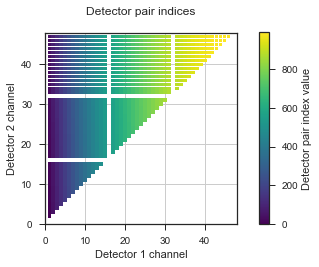

<Figure size 576x396 with 0 Axes>

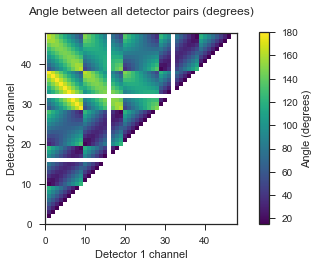

<Figure size 576x396 with 0 Axes>

In [7]:
det_df = bicorr.load_det_df('../../meas_info/det_df_pairs_angles.csv',plot_flag=True)

In [8]:
chList, fcList, detList, num_dets, num_det_pairs = bicorr.build_ch_lists(print_flag=True)

Fission chamber channels: [ 0 16 32]
Detector channels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Number of detectors: 45
Number of detector pairs: 990


# Calculate `num_fissions`

Sometime it would be convenient to store all of the measurement in a database, and then load it according to which datasets are specified in `note`. For now, input the data manually.

(Calculated in excel file `analysis_status.xlsx`)

In [18]:
num_fissions = int(int(sio.loadmat('datap/num_fissions.mat')['num_fissions'])*float(sio.loadmat('datap/fc_efficiency.mat')['fc_efficiency']))

In [19]:
num_fissions

1422133977

# Load data

## Load `sparse_bhm.npz`, revive `bhm`

In [20]:
os.listdir()

['.ipynb_checkpoints',
 'analysis_build_bhp_nn_by_pair_1_ns.ipynb',
 'analysis_experimental_setup_figs.ipynb',
 'datap',
 'fig',
 'plot_bhm_and_bhm_e.ipynb']

In [21]:
sparse_bhm, dt_bin_edges, note = bicorr.load_sparse_bhm(filepath='datap')

In [22]:
sparse_bhm.nbytes

306478678

In [23]:
bhm_pos = bicorr.revive_sparse_bhm(sparse_bhm, det_df, dt_bin_edges)

In [24]:
(bhm_pos.nbytes)/16 # .5 ns bins

633600000.0

I'm going to perform the background subtraction, then store `bhp_nn_diff` for all 990 pairs to disk so I can reload it later. 

## Load `sparse_bhm_neg.npz`, revive `bhm_neg`

In [26]:
sparse_bhm_neg, dt_bin_edges_neg, note_neg = bicorr.load_sparse_bhm(filename = 'sparse_bhm_neg.npz', filepath='datap')

In [27]:
bhm_neg = bicorr.revive_sparse_bhm(sparse_bhm_neg, det_df, dt_bin_edges_neg)

## Load `singles_hist.npz`

In [31]:
singles_hist, dt_bin_edges_sh, dict_det_to_index, dict_index_to_det = bicorr.load_singles_hist(filepath='datap')

In [32]:
help(bicorr.load_singles_hist)

Help on function load_singles_hist in module bicorr:

load_singles_hist(filename='singles_hist.npz', filepath=None, plot_flag=False, fig_folder='fig', show_flag=False, save_flag=False)
    Load existing singles histogram data.
    
    Parameters
    ----------
    filename : str, optional
        filename of singles_hist data
    filepath : str, optional
        location of singles_hist data. If None, in cwd
    plot_flag : bool, optional
        Whether to display plots
    fig_folder : str, optional
        Location for saving figure
    show_flag : bool, optional
        Whether to display figure to screen
    save_flag : bool, optional
        Whether to save figs to file
        
    Returns
    -------
    singles_hist : ndarray
        Histogram of singles timing information
        Dimension 0: particle type, 0=n, 1=g
        Dimension 1: detector channel
        Dimension 2: dt bin
    dt_bin_edges : ndarray
        Time bin edges array
    dict_det_to_index : dict
        Di

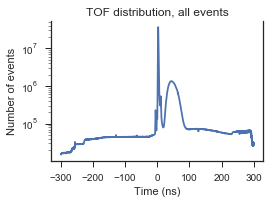

In [36]:
plt.figure(figsize=(4,3))
dt_bin_centers_sh = (dt_bin_edges_sh[:-1]+dt_bin_edges_sh[1:])/2
plt.plot(dt_bin_centers_sh,np.sum(singles_hist,axis=(0,1)))
plt.xlabel('Time (ns)')
plt.ylabel('Number of events')
plt.title('TOF distribution, all events')
plt.yscale('log')
sns.despine(right=False)
bicorr_plot.save_fig_to_folder('singles_hist_allt_allp',extensions=['png','pdf'])
plt.show()

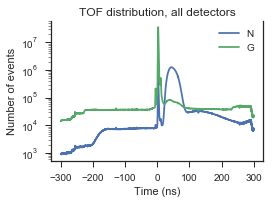

In [37]:
plt.figure(figsize=(4,3))
plt.plot(dt_bin_centers_sh,np.sum(singles_hist[0,:,:],axis=(0)))
plt.plot(dt_bin_centers_sh,np.sum(singles_hist[1,:,:],axis=(0)))
plt.xlabel('Time (ns)')
plt.ylabel('Number of events')
plt.title('TOF distribution, all detectors')
plt.legend(['N','G'])
plt.yscale('log')
sns.despine(right=False)
bicorr_plot.save_fig_to_folder('singles_hist_ng_allp',extensions=['png','pdf'])
plt.show()

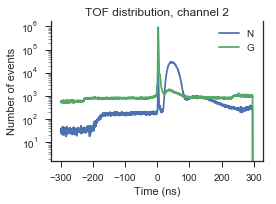

In [38]:
plt.figure(figsize=(4,3))
plt.plot(dt_bin_centers_sh,singles_hist[0,dict_det_to_index[2],:])
plt.plot(dt_bin_centers_sh,singles_hist[1,dict_det_to_index[2],:])
plt.xlabel('Time (ns)')
plt.ylabel('Number of events')
plt.title('TOF distribution, channel 2')
plt.legend(['N','G'])
plt.yscale('log')
sns.despine(right=False)
bicorr_plot.save_fig_to_folder('singles_hist_ng_ch2',extensions=['png','pdf'])
plt.show()

# Coarsen `bhm` to 1 ns. time binning.

In [39]:
print(bhm_pos.shape)
print(bhm_neg.shape)

(990, 4, 800, 800)
(990, 4, 800, 800)


In [40]:
bhm_pos, dt_bin_edges =     bicorr.coarsen_bhm(bhm_pos,dt_bin_edges,    4,True)
bhm_neg, dt_bin_edges_neg = bicorr.coarsen_bhm(bhm_neg,dt_bin_edges_neg,4,True)

Dimensions of bicorr_hist_master:  (990, 4, 800, 800)
Width of time bin in (ns):  0.25
Width of coarse time bin in (ns):  1.0
Condensing bhm from shape  (990, 4, 800, 800)  to  (990, 4, 200, 200)
Dimensions of bicorr_hist_master:  (990, 4, 800, 800)
Width of time bin in (ns):  0.25
Width of coarse time bin in (ns):  1.0
Condensing bhm from shape  (990, 4, 800, 800)  to  (990, 4, 200, 200)


In [41]:
print(bhm_pos.shape)
print(bhm_neg.shape)

(990, 4, 200, 200)
(990, 4, 200, 200)


# Produce `bhp` for $nn$ events

One key piece of data that I am going to work with for producing multiple plots is the `bhp` for $nn$ events across all detector pairs. (Actually, only the pairs not next to the fission chambers)

So I am going to produce that for future use. This will be copied into another notebook, but the process of loading all of the data is the same so I'm doing that here since all the data is loaded.

I'm going to make this with 1 ns time binning to keep the file size manageable.

## Produce `pair_is` for pairs not next to fission chamber

In [42]:
pair_is = bicorr.generate_pair_is(det_df, ignore_fc_neighbors_flag=True)
len(pair_is)

861

Look at this distribution.

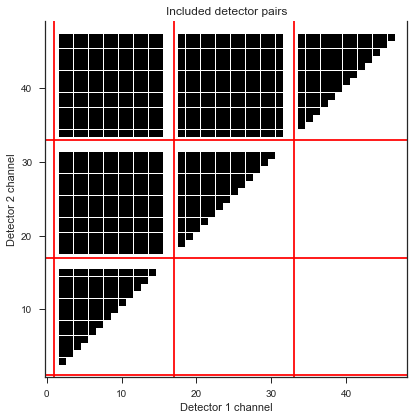

In [45]:
plt.figure(figsize=(6,6))
plt.plot(det_df.iloc[pair_is]['d1'],det_df.iloc[pair_is]['d2'],'sk')
for i in [1,17,33]:
    plt.axvline(i,c='r')
    plt.axhline(i,c='r')
plt.xlabel('Detector 1 channel')
plt.ylabel('Detector 2 channel')
plt.title('Included detector pairs')
sns.despine(right=False)
bicorr_plot.save_fig_to_folder(fig_filename='pair_is_without_fc_neighbors',extensions=['png','pdf'])
plt.show()

## Create `bhp_nn_pos`, `bhp_nn_neg`, `bhp_nn_diff`

Following instructions from `bicorr > methods > nn_sum_and_br_subtraction`.

I'm going to create arrays with 1 ns time binning and save them to disk, so I can easily reload them in the future. 

In [46]:
bhm_pos.shape

(990, 4, 200, 200)

In [47]:
bhm_pos_shape = bhm_pos[pair_is,:,:,:].shape
print(bhm_pos_shape)

(861, 4, 200, 200)


The challenge here is that I want to preserve the dimension of `pair_is` (I don't want to sum across all pairs in `pair_is`). How can I do this without significantly modifying my code base?

Set up arrays to fill

In [48]:
bhp_nn_pos = np.zeros((bhm_pos_shape[0],bhm_pos_shape[2],bhm_pos_shape[3]))
bhp_nn_neg = np.zeros((bhm_pos_shape[0],bhm_pos_shape[2],bhm_pos_shape[3]))

In [49]:
bhp_nn_neg.shape

(861, 200, 200)

In [50]:
for i in np.arange(len(pair_is)):
    pair_i = pair_is[i]
    
    bhp_nn_pos[i,:,:] = bicorr.build_bhp(bhm_pos,dt_bin_edges,pair_is=[pair_i],type_is=[0])[0]
    bhp_nn_neg[i,:,:] = bicorr.build_bhp(bhm_neg,dt_bin_edges_neg,pair_is=[pair_i],type_is=[0])[0]
    
print(bhp_nn_pos.shape)
print(bhp_nn_neg.shape)

(861, 200, 200)
(861, 200, 200)


Plot a few to make sure they look good.

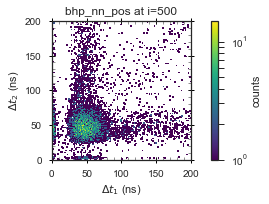

<Figure size 576x396 with 0 Axes>

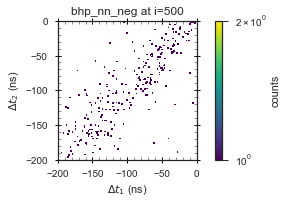

<Figure size 576x396 with 0 Axes>

In [54]:
i = 500
bicorr_plot.bhp_plot(bhp_nn_pos[i,:,:],dt_bin_edges,show_flag=True,title='bhp_nn_pos at i={}'.format(i))
bicorr_plot.bhp_plot(bhp_nn_neg[i,:,:],dt_bin_edges_neg,show_flag=True,title='bhp_nn_neg at i={}'.format(i))

Plot them now as sums across all pairs. 

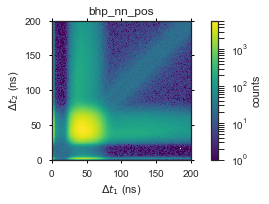

<Figure size 576x396 with 0 Axes>

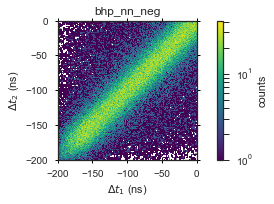

<Figure size 576x396 with 0 Axes>

In [55]:
bicorr_plot.bhp_plot(np.sum(bhp_nn_pos,axis=0),dt_bin_edges,show_flag=True,title='bhp_nn_pos')
bicorr_plot.bhp_plot(np.sum(bhp_nn_neg,axis=0),dt_bin_edges_neg,show_flag=True,title='bhp_nn_neg')

Now create `bhp_nn_diff`.

Question: Should I create `bhp_nn_diff` here, or work with `bhp_nn_pos` and `bhp_nn_neg`? The data is still pretty sparse, so `bhp_nn_diff` would end up with a lot of negative values in it. Mathematically, once I start taking sums, it would be the same. But I will always have to load `bhp_nn_pos` and `bhp_nn_neg` anyway, so I could just create `bhp_nn_diff` whenever I load them. Yeah. Do that. 

In [56]:
bhp_nn_diff = np.subtract(bhp_nn_pos.astype(np.int32),bhp_nn_neg[:,::-1,::-1].astype(np.int32))

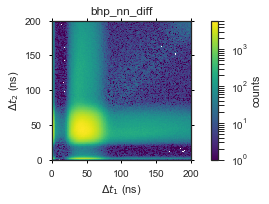

<Figure size 576x396 with 0 Axes>

In [57]:
bicorr_plot.bhp_plot(np.sum(bhp_nn_diff,axis=0),dt_bin_edges,show_flag=True,title='bhp_nn_diff')

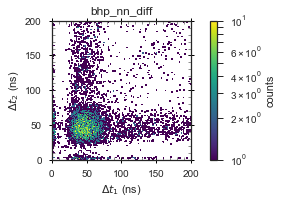

<Figure size 576x396 with 0 Axes>

In [58]:
i = 4
bicorr_plot.bhp_plot(bhp_nn_diff[i,:,:],dt_bin_edges,show_flag=True,title='bhp_nn_diff')

One thing to keep in mind is that `bicorr.bicorr_plot` does not show negative values, so the background subtraction makes it look "cleaner" than it is in reality.

## Verify `bhp_nn_diff`

Calculate `bhp_nn_diff` pair by pair and make sure it matches what I've already done. 

In [59]:
bhp_nn_diff_pair = np.zeros((861, 200, 200))

In [60]:
for i in np.arange(len(pair_is)):
    pair_i = pair_is[i]
    bhp_nn_diff_pair[i,:,:] = np.subtract(bhp_nn_pos[i,:,:].astype(np.int32),bhp_nn_neg[i,::-1,::-1].astype(np.int32))

In [61]:
bhp_nn_diff_pair.shape

(861, 200, 200)

In [62]:
np.array_equal(bhp_nn_diff,bhp_nn_diff_pair)

True

# Store `bhp_nn_pos`, `bhp_nn_neg`

* `bhp_nn_neg, bhp_nn_pos`
* `dt_bin_edges`
* `pair_is`
* `note`

Save these four arrays and the note to the same `.npz` file

In [63]:
note = 'Stored from Cf072115_to_Cf072215b with 1 ns time binning. Pairs are without fc neighbors. -PFS, 2/9/18'

In [64]:
save_filename = 'datap/bhp_nn_by_pair_1ns'

In [65]:
np.savez(save_filename, bhp_nn_neg = bhp_nn_neg, bhp_nn_pos = bhp_nn_pos,
         dt_bin_edges = dt_bin_edges, pair_is = pair_is, note = note)

# Reload instructions

In my other analysis files, I'm going to load these variables from disk.

Restart the notebook so I start fresh and start from here. 

In [1]:
whos

Interactive namespace is empty.


Go back and import all the packages.

In [7]:
whos

Variable     Type      Data/Info
--------------------------------
bicorr       module    <module 'bicorr' from '../../scripts\\bicorr.py'>
imageio      module    <module 'imageio' from 'C<...>s\\imageio\\__init__.py'>
matplotlib   module    <module 'matplotlib' from<...>matplotlib\\__init__.py'>
np           module    <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
os           module    <module 'os' from 'C:\\Us<...>\\Anaconda3\\lib\\os.py'>
plt          module    <module 'matplotlib.pyplo<...>\\matplotlib\\pyplot.py'>
sns          module    <module 'seaborn' from 'C<...>s\\seaborn\\__init__.py'>
sys          module    <module 'sys' (built-in)>


In [8]:
load_filename = 'datap/bhp_nn_by_pair_1ns.npz'

In [12]:
npzfile = np.load(load_filename)
print(npzfile.files)
print(npzfile['note'])

['pair_is', 'note', 'bhp_nn_pos', 'bhp_nn_neg', 'dt_bin_edges']
Stored from Cf072115_to_Cf072215b with 1 ns time binning. Pairs are without fc neighbors. -PFS, 2/9/18


In [15]:
pair_is = npzfile['pair_is']
bhp_nn_pos = npzfile['bhp_nn_pos']
bhp_nn_neg = npzfile['bhp_nn_neg']
dt_bin_edges = npzfile['dt_bin_edges']

Calculate `bhp_nn_diff`.

In [19]:
bhp_nn_diff = np.subtract(bhp_nn_pos.astype(np.int32),bhp_nn_neg[:,::-1,::-1].astype(np.int32))

In [20]:
bhp_nn_diff.shape

(861, 200, 200)

Plot them to make sure they look good. 

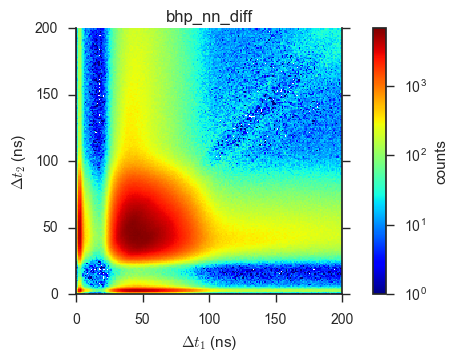

In [21]:
bicorr.bicorr_plot(np.sum(bhp_nn_diff,axis=0),dt_bin_edges,show_flag=True,title='bhp_nn_diff')